In [1]:
import tensorflow as tf
import os
import glob
from matplotlib import pyplot as plt
%matplotlib inline
import time

tf.__version__

'2.6.0'

In [2]:
imgs_path = glob.glob('data/train/*.png')
len(imgs_path)

14224

In [3]:
len(imgs_path)

14224

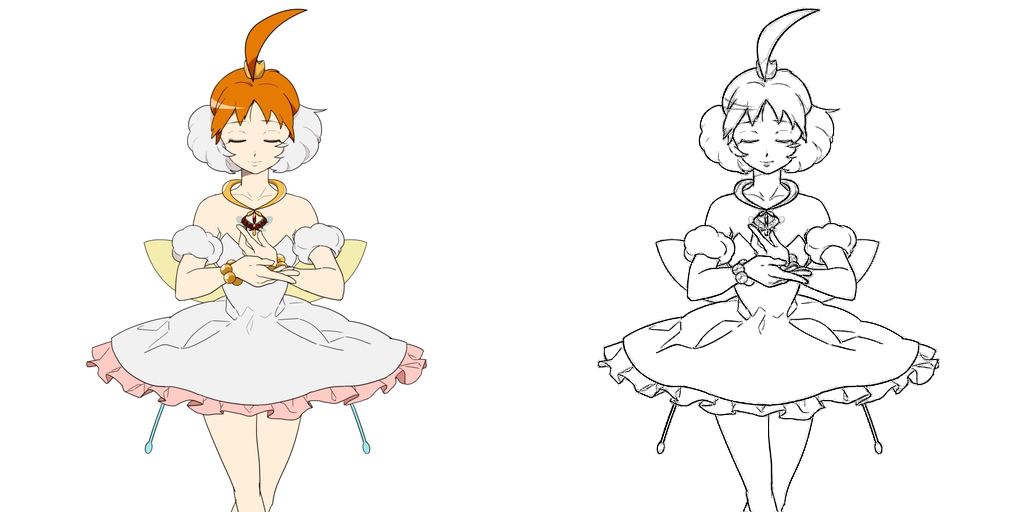

In [4]:
import random
img = tf.keras.preprocessing.image.load_img(random.choice(imgs_path))
img

In [5]:
imgs_path[:3]

['data/train\\1000000.png', 'data/train\\10001.png', 'data/train\\10007.png']

In [6]:
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [7]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)/127.5 - 1
    input_mask = tf.cast(input_mask, tf.float32)/127.5 - 1
    return input_image, input_mask

In [8]:
def load_image(image_path):
    image = read_jpg(image_path)
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, :w, :]
    input_mask = image[:, w:, :]
    input_image = tf.image.resize(input_image, (256, 256))
    input_mask = tf.image.resize(input_mask, (256, 256))
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_mask, input_image

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(imgs_path)

In [10]:
train = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train

<ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 3)), types: (tf.float32, tf.float32)>

In [11]:
BATCH_SIZE = 32
BUFFER_SIZE = 200

In [12]:
train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

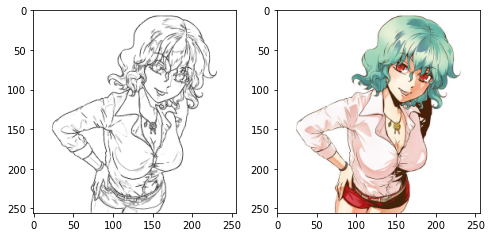

In [13]:
plt.figure(figsize=(8, 5))
for img, musk in train_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(musk[0]))

In [14]:
imgs_path_test = glob.glob('data/val/*.png')
len(imgs_path_test)

3545

In [15]:
dataset_test = tf.data.Dataset.from_tensor_slices(imgs_path_test)

In [16]:
def load_image_test(image_path):
    image = read_jpg(image_path)
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, :w, :]
    input_mask = image[:, w:, :]
    input_image = tf.image.resize(input_image, (256, 256))
    input_mask = tf.image.resize(input_mask, (256, 256))
    
    input_image, input_mask = normalize(input_image, input_mask)

    return input_mask, input_image

In [17]:
dataset_test = dataset_test.map(load_image_test)

In [18]:
dataset_test = dataset_test.batch(BATCH_SIZE)

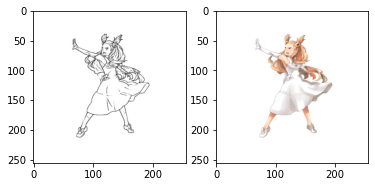

In [19]:
for img, musk in dataset_test.take(1):
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(musk[0]))

In [20]:
OUTPUT_CHANNELS = 3

In [21]:
def downsample(filters, size, apply_batchnorm=True):
#    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

        result.add(tf.keras.layers.LeakyReLU())

    return result

In [22]:
def upsample(filters, size, apply_dropout=False):
#    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [23]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

#    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [24]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [25]:
LAMBDA = 10

In [26]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [27]:
def Discriminator():
#    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  padding='same',
                                  use_bias=False)(down3) # (bs, 32, 32, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    last = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same')(leaky_relu) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [28]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [29]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [32]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

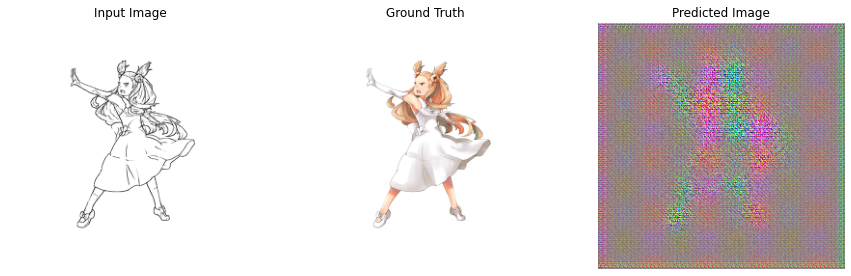

In [33]:
for example_input, example_target in dataset_test.take(1):
    generate_images(generator, example_input, example_target)

In [34]:
EPOCHS = 100

In [35]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    return gen_total_loss, disc_loss

In [36]:
epoch_loss_avg_gen = tf.keras.metrics.Mean('g_loss')
epoch_loss_avg_disc = tf.keras.metrics.Mean('d_loss')

In [37]:
g_loss_results = []
d_loss_results = []

In [38]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs+1):
        if epoch%10 == 0:
            for example_input, example_target in test_ds.take(1):
                generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            g_loss, d_loss = train_step(input_image, target, epoch)
            epoch_loss_avg_gen(g_loss)
            epoch_loss_avg_disc(d_loss)
        print()
        g_loss_results.append(epoch_loss_avg_gen.result())
        d_loss_results.append(epoch_loss_avg_disc.result())
        
        epoch_loss_avg_gen.reset_states()
        epoch_loss_avg_disc.reset_states()

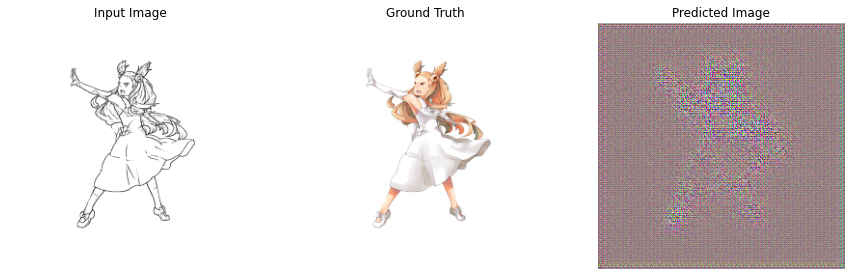

Epoch:  0
...............................

KeyboardInterrupt: 

In [39]:
fit(train_dataset, EPOCHS, dataset_test)

In [ ]:
generator.save('pix2pix0.h5')

In [ ]:

for input_image, ground_true in dataset_test:
    generate_images(generator, input_image, ground_true)

In [ ]:
generator=tf.keras.models.load_model("pix2pix0.h5")

In [ ]:
for input_image, ground_true in dataset_test:
    generate_images(generator, input_image, ground_true)

In [ ]:
import pickle
gener = "pix2pix0.pickle"
with open(gener,'wb') as f:
pickle.dump(train_model_name, f)

In [ ]:
#model_weights_path = os.path.join(output_dir, 'model_weights.h5')
model_weights_path = './pix2pix0.h5'
model_weights_path
print(str(model_weights_path))
tf.keras.models.save_model(generator, model_weights_path)   

print("Saved model weights to disk")

In [ ]:
with("pix2pix0",'wb') as f:
    pickle.dump(generator,f)